In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from surprise import SVD,Dataset,Reader



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Preprocessing data and EDA

In [2]:
anime=pd.read_csv('./anime.csv')
rating=pd.read_csv('./rating.csv')


In [3]:
anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [4]:
rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [5]:

print(anime.isnull().sum())
print("---------------------")
print(rating.isnull().sum())



anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64
---------------------
user_id     0
anime_id    0
rating      0
dtype: int64


In [6]:
#droping the null values in anime df
#replacing ratings which are -1 to nan in rating column in rating df
anime=anime.dropna()
rating.rating.replace(-1, np.NaN,inplace=True)


In [7]:
for text in anime['name']:
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    

In [8]:
#merging anime dataframe and ratign df
df=pd.merge(anime,rating,on='anime_id',suffixes= ['', '_user'])
df = df.rename(columns={'rating_user': 'user_rating'})
df.head(10)

,anime_id,name,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,NaN
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10.0
6,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,398,10.0
7,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,462,8.0
8,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,490,10.0
9,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,548,10.0


## variations of ratings by anime type


In [9]:
fig = px.histogram(anime.dropna(subset=['rating']), x='rating', color='type',
                   histnorm='density', nbins=100, opacity=0.5,
                   barmode='overlay', range_x=[0, 10])
fig.update_layout(xaxis=dict(dtick=2.5))


fig.show()


## How many animes does people rate


* ### Movies seem to have the highest variance, and also it looks somewhat bimodal
* ### OVAs and Specials seem to have the steepest peak around their average
* ### TV seems (oddly) to be rated higher than everything else.




(0.0, 600.0)

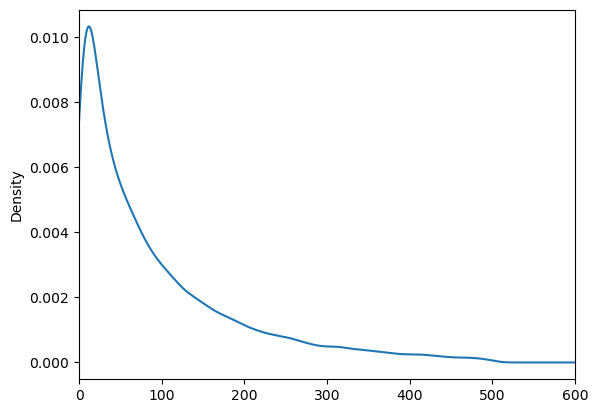

In [10]:
g = rating.groupby('user_id').size().reset_index(name='n')
g = g[g['n'] < 500]

# Density plot using matplotlib
fig, ax = plt.subplots()
ax = g['n'].plot.density()
ax.set_xlim(0, 600)


* ### we can see that not many users rate the anime

## How consistently does people rate

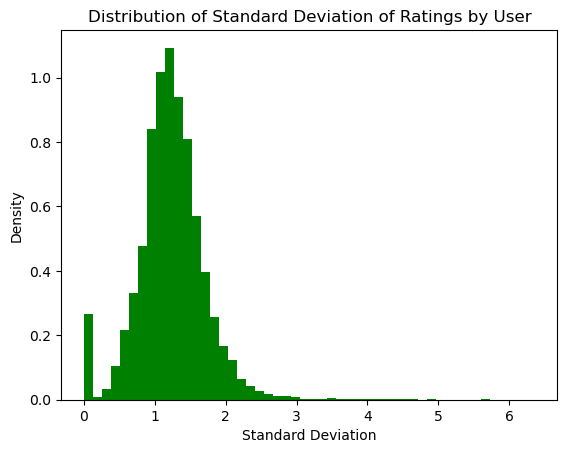

In [11]:
g = rating.groupby('user_id')['rating'].std().reset_index(name='sd')
# fig = px.histogram(g, x='sd', nbins=50)
# fig.show()
plt.hist(g['sd'], bins=50, density=True,color="green")
plt.xlabel('Standard Deviation')
plt.ylabel('Density')
plt.title('Distribution of Standard Deviation of Ratings by User')

# Display the plot
plt.show()

* ### Some people have only a single rating (likely the spike at 0)
* ### A lot of people shuffle their ratings 1-2 points.
* ### Some people have huge variance.

Text(0.5, 1.0, 'Distribution of Mean of Ratings by User')

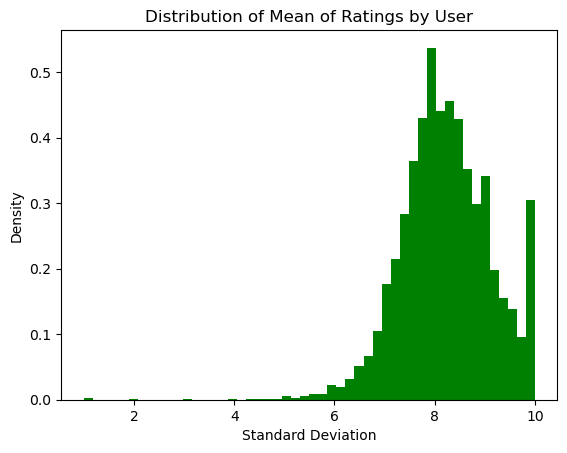

In [12]:
g = rating.groupby('user_id')['rating'].mean().reset_index(name='m')
# fig = px.histogram(g, x='sd', nbins=50)
# fig.show()
plt.hist(g['m'], bins=50, density=True,color="green")
plt.xlabel('Standard Deviation')
plt.ylabel('Density')
plt.title('Distribution of Mean of Ratings by User')

* ### In general, most people rate the shows they like.
* ### Some people only ratings things 10/10.
* ### Most people rating things, on average, around an 8.0/10.


## Top animes based on rating

Text(0, 0.5, 'User Rating count')

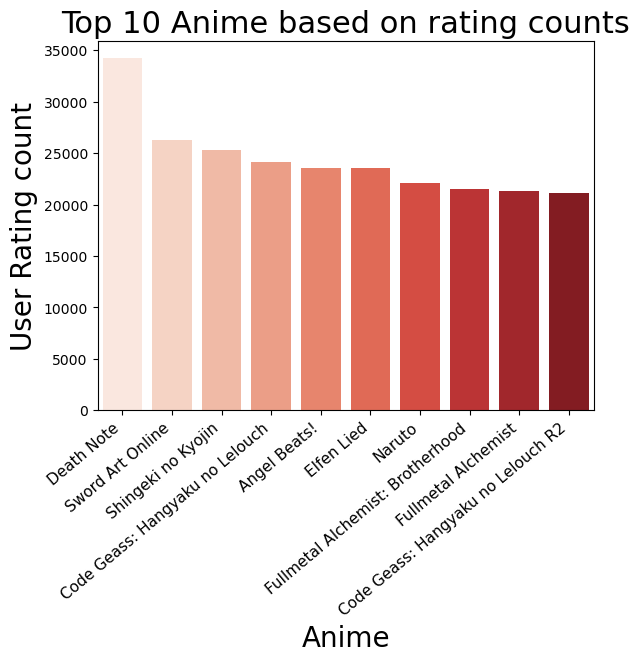

In [13]:
combine_anime_rating = df.dropna(axis = 0, subset = ['name'])
anime_ratingCount = (combine_anime_rating.
     groupby(by = ['name'])['user_rating'].
     count().
     reset_index().rename(columns = {'rating': 'totalRatingCount'})
    [['name', 'user_rating']]
    )


top10_animerating=anime_ratingCount[['name', 'user_rating']].sort_values(by = 'user_rating',ascending = False).head(10)
ax=sns.barplot(x="name", y="user_rating", data=top10_animerating, palette="Reds")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on rating counts',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)

## Popularity of genres

In [14]:
all_genres = all_genres = defaultdict(int)
for i in df['genre']:
    for j in i.split(','):
        all_genres[j.strip()] += 1
all_genres=dict(all_genres)
print(all_genres)
print(type(all_genres))
all_genres = dict(sorted(all_genres.items(), key=lambda x: x[1]))


{'Drama': 2101320, 'Romance': 2487902, 'School': 1884897, 'Supernatural': 1964112, 'Action': 3263393, 'Adventure': 1695965, 'Fantasy': 2021336, 'Magic': 769540, 'Military': 440336, 'Shounen': 1882227, 'Comedy': 3908785, 'Historical': 375688, 'Parody': 279925, 'Samurai': 117608, 'Sci-Fi': 1613124, 'Thriller': 349914, 'Sports': 243581, 'Super Power': 781064, 'Space': 178230, 'Slice of Life': 1098829, 'Mecha': 566502, 'Music': 205146, 'Mystery': 899054, 'Seinen': 752464, 'Martial Arts': 263859, 'Vampire': 227840, 'Shoujo': 493460, 'Horror': 440211, 'Police': 170742, 'Psychological': 567722, 'Demons': 335049, 'Ecchi': 954749, 'Josei': 76203, 'Shounen Ai': 59720, 'Game': 213663, 'Dementia': 66197, 'Harem': 760586, 'Cars': 21333, 'Kids': 133863, 'Shoujo Ai': 68175, 'Hentai': 101475, 'Yaoi': 29168, 'Yuri': 7436}
<class 'dict'>


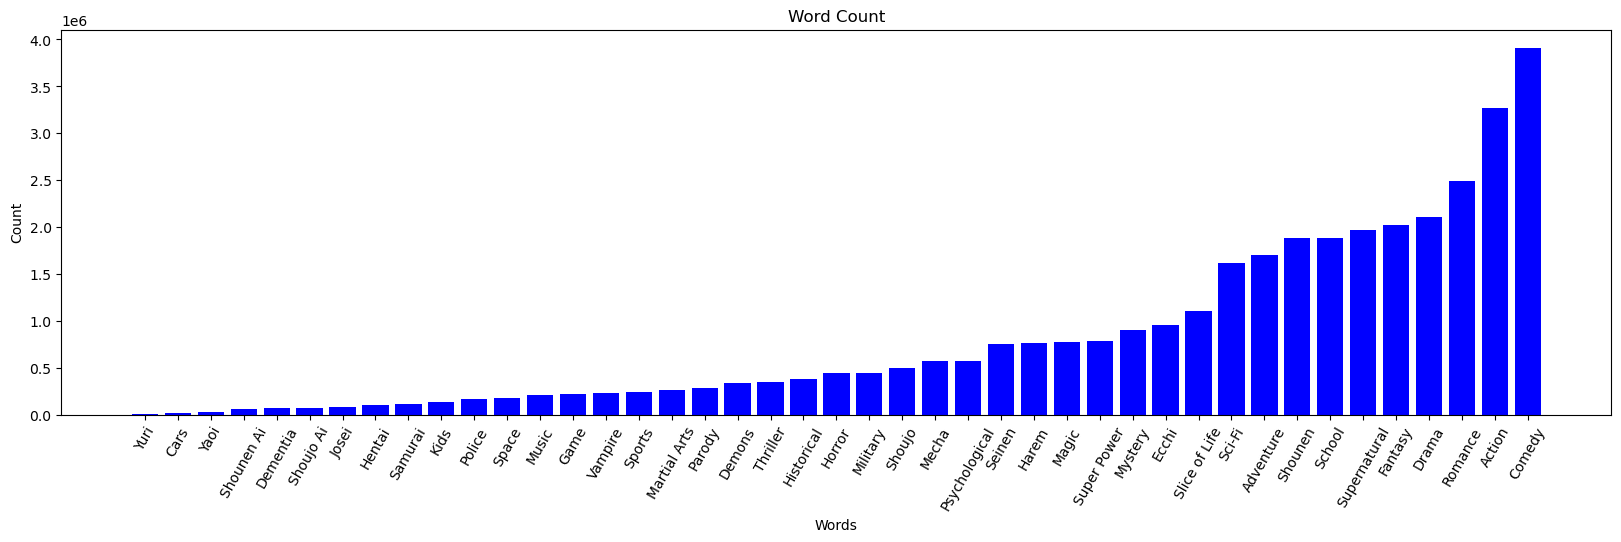

In [15]:

keys = list(all_genres.keys())
values = list(all_genres.values())
plt.figure(figsize=(20, 5))
plt.bar(keys, values, color='blue')
plt.title("Word Count")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=60)
plt.show()

* ### We can sense there are many Comedy genre anime's followd by action, romance,drama in our dataset



# Collaborative Filtering

Collaborative filtering can be done using creating a pivot table, since the data is huge it takes lot of time to create the pivot table so we are taking only 20,000 users

In [16]:
df_collab=df[['user_id', 'name', 'user_rating']]
df_collab=df_collab.dropna()
df_collab= df_collab[df_collab.user_id <= 20000]
#creating pivot table
pivot_table= df_collab.pivot_table(index=['user_id'], columns=['name'], values='user_rating')

#normalizing
normalised_pivot_table = pivot_table.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
# Drop all columns containing only zeros representing users who did not rate
normalised_pivot_table.fillna(0, inplace=True)
normalised_pivot_table = normalised_pivot_table.T
normalised_pivot_table = normalised_pivot_table.loc[:, (normalised_pivot_table != 0).any(axis=0)]
#converting pivot table into sparse matrix
sparse_matrix = csr_matrix(normalised_pivot_table.values)
#getting item_similaroty anf user similarity
item_similarity = cosine_similarity(sparse_matrix)
user_similarity = cosine_similarity(sparse_matrix.T)

#make item and user similarity matrices into df
item_sim_df = pd.DataFrame(item_similarity, index = normalised_pivot_table.index, columns = normalised_pivot_table.index)
user_sim_df = pd.DataFrame(user_similarity, index = normalised_pivot_table.columns, columns = normalised_pivot_table.columns)





In [17]:
def item_collaborative_filtering_recommendation(anime_name,top_n):
    count = 1
    print('Similar shows to {} include:\n'.format(anime_name))
    for item in item_sim_df.sort_values(by = anime_name, ascending = False).index[1:top_n+1]:
        print('No. {}: {}'.format(count, item))
        count +=1  

In [18]:
def user_collaborative_filtering_recommendation(usr_id,top_n):
    user_similarity_scores = user_sim_df[usr_id].sort_values(ascending=False)
    most_similar_users = user_similarity_scores[1:top_n]
    similar_user_ratings = normalised_pivot_table[most_similar_users.index]
    recommendations = (similar_user_ratings * most_similar_users).sum(axis=1) / most_similar_users.sum()
    recommendations = list(recommendations.sort_values(ascending=False).index[:10])
    for i in range(len(recommendations)):
        print("No. ",i+1,":",recommendations[i])

In [19]:
item_collaborative_filtering_recommendation('Death Note',10)


Similar shows to Death Note include:

No. 1: Code Geass: Hangyaku no Lelouch R2
No. 2: Code Geass: Hangyaku no Lelouch
No. 3: Fullmetal Alchemist: Brotherhood
No. 4: Steins;Gate
No. 5: Shingeki no Kyojin
No. 6: Clannad: After Story
No. 7: One Punch Man
No. 8: Kiseijuu: Sei no Kakuritsu
No. 9: Hunter x Hunter (2011)
No. 10: Fate/Zero 2nd Season


In [20]:

user_collaborative_filtering_recommendation(6969,10)

No.  1 : Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.
No.  2 : Steins;Gate
No.  3 : Fate/Zero 2nd Season
No.  4 : Durarara!!
No.  5 : Fullmetal Alchemist: Brotherhood
No.  6 : Suzumiya Haruhi no Shoushitsu
No.  7 : Bakemonogatari
No.  8 : Fate/stay night: Unlimited Blade Works 2nd Season
No.  9 : Mahou Shoujo Madoka★Magica
No.  10 : Monogatari Series: Second Season


In [21]:
mean_rating = df_collab.groupby('user_id')['user_rating'].mean()

# Subtract the mean rating from each user's rating to get the mean centered rating
df_collab['mean_centered_rating'] = df_collab['user_rating'] - df_collab['user_id'].map(mean_rating)

# Assign weights to each user based on some criteria (e.g. number of ratings, recency of ratings, etc.)
# For simplicity, let's assume equal weights of 1 for each user
df_collab['weight'] = 1

# Calculate the weighted average mean centered rating by multiplying the mean centered rating by the weight and dividing by the sum of weights
df_collab['weighted_average_mean_centered_rating'] = df_collab['mean_centered_rating'] * df_collab['weight'] / df_collab['weight'].sum()

# Print the dataframe
from sklearn.metrics import recall_score, precision_score

# Define a function to binarize ratings into positive (1) or negative (0) based on a threshold
def binarize(rating, threshold):
  if rating >= threshold:
    return 1
  else:
    return 0

# Apply the function to both user_rating and true_rating columns with a threshold of 3 (you can change this as you like)
df_collab['user_rating_binary'] = df_collab['user_rating'].apply(lambda x: binarize(x, 3))
df_collab['true_rating_binary'] = df_collab['user_rating'].apply(lambda x: binarize(x, 3))

# Calculate recall and precision by comparing user_rating_binary and true_rating_binary columns
recall = recall_score(df_collab['true_rating_binary'], df_collab['user_rating_binary'])
precision = precision_score(df_collab['true_rating_binary'], df_collab['user_rating_binary'])

# Print recall and precision
print('Recall:', recall)
print('Precision:', precision)


Recall: 1.0
Precision: 1.0


# Content Based recomendation


In [22]:
anime_features=anime[['genre', 'type', 'episodes']].astype('str')
anime_features["genre"]
anime_features["genre"]=anime_features["genre"].str.split(',').str.join(' ')
anime_features

,genre,type,episodes
0,Drama Romance School Supernatural,Movie,1
1,Action Adventure Drama Fantasy Magic Mili...,TV,64
2,Action Comedy Historical Parody Samurai S...,TV,51
3,Sci-Fi Thriller,TV,24
4,Action Comedy Historical Parody Samurai S...,TV,51
...,...,...,...
12289,Hentai,OVA,1
12290,Hentai,OVA,1
12291,Hentai,OVA,4
12292,Hentai,OVA,1


In [23]:
#creating tf-idf 
tf_idf = TfidfVectorizer(stop_words='english')
anime_matrix = tf_idf.fit_transform(anime_features.apply(lambda x: ' '.join(x), axis=1))
cosine_similarities = cosine_similarity(anime_matrix)   #creating cosine similarity
#creating alist whoch contains all anime names
anime_names=anime["name"]
indices = pd.Series(anime.index, index=anime['name'])

In [24]:
def get_recommendations(anime_name,k):
    idx = indices[anime_name]
    # Get the pairwise similarity scores
    sim_scores = list(enumerate(cosine_similarities[idx]))
    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the k most similar anime
    sim_scores = sim_scores[1:k+1]
    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]
    # Return the top k most similar anime
    print( anime_names.iloc[anime_indices])

In [25]:
get_recommendations("Death Note",10)

778                           Death Note Rewrite
981                              Mousou Dairinin
1383               Higurashi no Naku Koro ni Rei
144                Higurashi no Naku Koro ni Kai
445                             Mirai Nikki (TV)
334                    Higurashi no Naku Koro ni
1229                                Gallery Fake
5592                   Kikou Keisatsu Metal Jack
5382                                   AD Police
2074    Higurashi no Naku Koro ni Kaku: Outbreak
Name: name, dtype: object


In [26]:
get_recommendations("Doraemon",5)

5118        Saru Getchu: On Air
5244    Fushigi na Koala Blinky
2510            Bosco Daibouken
5159         Suhoyojeong Michel
5509        Asobou! Hello Kitty
Name: name, dtype: object
